In [ ]:
#| default_exp datasets.core
#| default_cls_lvl 3

In [ ]:
#| export
from fastai.data.all import *
from tsfast.data import *

from tsfast.data.loader import *
import h5py
from nbdev.config import get_config
from shutil import rmtree
import warnings

In [ ]:
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/WienerHammerstein'
hdf_files = get_files(f_path,extensions='.hdf5',recurse=True)
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput,padding=True,cached=None),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput,cached=None)),
                get_items=CreateDict([DfHDFCreateWindows(win_sz=100+1,stp_sz=100,clm='u')]),
                splitter=ApplyToDict(ParentSplitter()))
dls = seq.dataloaders(hdf_files)

creating a Dataloader manually for each Dataset is cumbersome. The flexibility of the datablocks api is not needed when we can take some assumptions.
1. The individual .hdf5 files have a "train", "valid" and "test" parent directory which divides them
2. All input and output signals are 1d and have the same length

To implement this function, we need to store the normalization parameters of a dataset into a file, so a trained model can work with the dataset even when it is loaded again.

We assume that the dataloader always provides normalized data. When the model is deployed, it has to normalize the data itself.

In [ ]:
#| export
def extract_mean_std_from_dls(dls):
    normalize = first(dls.after_batch,f=lambda x: type(x)==Normalize)
    norm_mean = normalize.mean.detach().cpu()
    norm_std = normalize.std.detach().cpu()
    return norm_mean,norm_std

In [ ]:
extract_mean_std_from_dls(dls)

(TensorSequencesInput([[[-0.0196, -0.0483]]]),
 TensorSequencesInput([[[0.6566, 0.2253]]]))

In [ ]:
test_eq(type(extract_mean_std_from_dls(dls)),tuple)
test_eq(len(extract_mean_std_from_dls(dls)),2)

In [ ]:
#| export
def dict_file_save(key,value,f_path='dls_normalize.p'):
    'save value to a dictionary file, appends if it already exists'
    
    #use the absolute path, so seperate processes refer to the same file
    f_path = Path(f_path)
    try:
        with open( f_path, "rb" ) as f:
            dictionary = pickle.load( f )
    except OSError as e:
        dictionary = {}
    dictionary[key] = value
        
    with open( f_path, "wb" ) as f:
        pickle.dump(dictionary,f)

In [ ]:
val = [1,2,5]
dict_file_save('tst_key',val)

In [ ]:
#| export
def dict_file_load(key,f_path='dls_normalize.p'):
    'load value from a dictionary file'

    #use the absolute path, so seperate processes refer to the same file
    f_path = Path(f_path)
    try:
        with open( f_path, "rb" ) as f:
            dictionary = pickle.load( f )
        if key in dictionary:
            return dictionary[key]
    except OSError as e:
        print(f'{f_path} not found')
    return None

In [ ]:
test_eq(dict_file_load('tst_key'),val)

In [ ]:
#| export
def extract_mean_std_from_hdffiles(
        lst_files, #List of paths to HDF5 files
        lst_signals #List of signal names, each a dataset within the HDF5 files
        ):
    'Calculate the mean and standard deviation of the signals from the provided HDF5 files.'
    if len(lst_signals) == 0: return (None,None)

    # Initialize accumulators for mean and squared mean
    sums = np.zeros(len(lst_signals))
    squares = np.zeros(len(lst_signals))
    counts = 0
    
    # Process each file
    for file in lst_files:
        with h5py.File(file, 'r') as f:
            for i, signal in enumerate(lst_signals):
                data = f[signal][:]
                if data.ndim > 1: raise ValueError(f'Each dataset in a file has to be 1d. {signal} is {data.ndim}.')
                sums[i] += np.sum(data)
                squares[i] += np.sum(data ** 2)
                
        counts += data.size
    
    # Calculate the mean and standard deviation across all files
    means = sums / counts
    stds = np.sqrt((squares / counts) - (means ** 2))
    
    return means.astype(np.float32), stds.astype(np.float32)

In [ ]:
extract_mean_std_from_hdffiles(hdf_files,['u','y'])

(array([-0.00387449, -0.03890106], dtype=float32),
 array([0.65983725, 0.23847243], dtype=float32))

In [ ]:
#| export
def extract_mean_std_from_dataset(lst_files,u,x,y):
    train_files = lst_files[ParentSplitter()(lst_files)[0]]
    norm_u = extract_mean_std_from_hdffiles(train_files,u)
    norm_x = extract_mean_std_from_hdffiles(train_files,x)
    norm_y = extract_mean_std_from_hdffiles(train_files,y)
    return (norm_u,norm_x,norm_y)

In [ ]:
extract_mean_std_from_dataset(hdf_files,['u'],[],['y'])

((array([-0.00387546], dtype=float32), array([0.6569116], dtype=float32)),
 (None, None),
 (array([-0.0389192], dtype=float32), array([0.23567446], dtype=float32)))

In [ ]:
#| export
def is_dataset_directory(ds_path):
    """
    Checks if the given directory path is a dataset with hdf5 files.
    
    :param ds_path: The path to the directory to check.
    :return: True if the directory contains 'train', 'valid', and 'test' subdirectories,
             each of which must contain at least one HDF5 file. False otherwise.
    """
    required_dirs = ['train', 'valid', 'test']
    
    # Check if all required directories exist and contain HDF5 files
    for dir_name in required_dirs:
        dir_path = os.path.join(ds_path, dir_name)
        if not os.path.exists(dir_path) or not os.path.isdir(dir_path):
            return False  # Directory missing
        hdf_files = get_hdf_files(dir_path, recurse=True)
        if not hdf_files:
            return False  # No HDF5 files found in this directory

    return True  # All checks passed

In [ ]:
test_eq(is_dataset_directory(f_path),True)
test_eq(is_dataset_directory(f_path.parent),False)

In [ ]:
#| export
def create_dls(
        u, #list of input signal names
        y, #list of output signal names
        dataset:Path|list, #path to dataset with train,valid and test folders, or list of filepaths
        win_sz:int = 100, #initial window size
        x:list =[], #optional list of state signal names
        stp_sz:int = 1, #step size between consecutive windows
        sub_seq_len:int = None, #if provided uses truncated backpropagation throug time with this sub sequence length 
        bs:int = 64, #batch size
        prediction:bool = False, #if true, the output is concatenated to the input, mainly for prediction tasks
        input_delay:bool = False, #if true, the input is delayed by one step
        valid_stp_sz:int = None, #step size between consecutive validation windows, defaults to win_sz
        cached:bool = True, #if true, the data is cached in RAM
        num_workers:int = 5, #number of processes for the dataloader, 0 for no multiprocessing
        n_batches_train:int|None = 300, #exact number of training batches per epoch
        n_batches_valid:int|None = None, #exact number of validation batches per epoch
        max_batches_training:int|None = None, #DEPRECATED: limits the number of training batches in a single epoch
        max_batches_valid:int|None = None, #DEPRECATED: limits the number of validation batches in a single epoch
        dls_id:str = None #identifier for the dataloader to cache the normalization values, does not cache when not provided
    ):
    if valid_stp_sz is None: valid_stp_sz = win_sz

    #extract list of dataset files
    if isinstance(dataset, (Path,str)):
        hdf_files = get_hdf_files(dataset)
    elif isinstance(dataset,(list,tuple,L)):
        hdf_files = dataset
    else:
        raise ValueError(f'dataset has to be a Path or filelist. {type(dataset)} was given.')
    
    #extract the normalization parameters for input, state and output
    if dls_id is not None:
        norm = dict_file_load(dls_id)
        if norm is None: 
            norm = extract_mean_std_from_dataset(hdf_files,u,x,y)
            dict_file_save(dls_id,norm)
        (norm_u,norm_x,norm_y) = norm
    else:
        #use all provided training data for deterministic results, in case caching is not activated
        (norm_u,norm_x,norm_y) = extract_mean_std_from_dataset(hdf_files,u,x,y)
    
    #choose input and output signal blocks
    if prediction:
        if input_delay: #if true, the input is delayed by one step
            blocks = (SequenceBlock.from_hdf(u+x+y,TensorSequencesInput,clm_shift=[-1]*len(u+x+y),cached=cached),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput,clm_shift=[1]*len(y),cached=cached))
        else:
            blocks = (SequenceBlock.from_hdf(u+x+y,TensorSequencesInput,clm_shift=([0]*len(u)+[-1]*len(x+y)),cached=cached),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput,clm_shift=[1]*len(y),cached=cached))
        tup_norm = (norm_u,norm_y) if len(x) == 0 else (norm_u,norm_x,norm_y)
        norm_mean = np.hstack([n[0] for n in tup_norm])
        norm_std = np.hstack([n[1] for n in tup_norm])
    else:
        blocks = (SequenceBlock.from_hdf(u,TensorSequencesInput,cached=cached),
                SequenceBlock.from_hdf(y,TensorSequencesOutput,cached=cached))
        norm_mean,norm_std = norm_u


    seq = DataBlock(blocks=blocks,
                     get_items=CreateDict([DfApplyFuncSplit(
                            ParentSplitter(),
                            DfHDFCreateWindows(win_sz=win_sz,stp_sz=stp_sz,clm=u[0]),
                            DfHDFCreateWindows(win_sz=win_sz,stp_sz=valid_stp_sz,clm=u[0])
                        )]),
                     batch_tfms=Normalize(mean=torch.from_numpy(norm_mean[None,None,:]),std=torch.from_numpy(norm_std[None,None,:]),axes=(0, 1)),
                     splitter=ParentSplitter())
    
    # Determine which factory to use based on parameters
    use_old_factory = False
    if max_batches_training is not None or max_batches_valid is not None:
        # Old parameters provided
        if n_batches_train is not None or n_batches_valid is not None:
            # Both old and new provided - new takes precedence
            warnings.warn(
                "Both old ('max_batches_training', 'max_batches_valid') and new ('n_batches_train', 'n_batches_valid') "
                "parameters provided. Using new parameters. Old parameters are deprecated.",
                DeprecationWarning,
                stacklevel=2
            )
        else:
            # Only old parameters - use old factory with warning
            warnings.warn(
                "Parameters 'max_batches_training' and 'max_batches_valid' are deprecated. "
                "Use 'n_batches_train' and 'n_batches_valid' instead.",
                DeprecationWarning,
                stacklevel=2
            )
            use_old_factory = True
    
    if use_old_factory:
        # Use deprecated BatchLimit_Factory for backwards compatibility
        if sub_seq_len is None:
            dl_kwargs=[{'max_batches':max_batches_training},
                       {'max_batches':max_batches_valid}]
            dl_type = BatchLimit_Factory(TfmdDL)
        else:
            dl_kwargs=[{'sub_seq_len':sub_seq_len,'max_batches':max_batches_training},
                       {'sub_seq_len':sub_seq_len,'max_batches':max_batches_valid}]
            dl_type = BatchLimit_Factory(TbpttDl)
    else:
        # Use new NBatches_Factory
        if sub_seq_len is None:
            dl_kwargs=[{'n_batches':n_batches_train},
                       {'n_batches':n_batches_valid}]
            dl_type = NBatches_Factory(TfmdDL)
        else:
            dl_kwargs=[{'sub_seq_len':sub_seq_len,'n_batches':n_batches_train},
                       {'sub_seq_len':sub_seq_len,'n_batches':n_batches_valid}]
            dl_type = NBatches_Factory(TbpttDl)
        
    dls = seq.dataloaders(hdf_files,bs=bs,num_workers=num_workers,
                          dl_type=dl_type,dl_kwargs=dl_kwargs)

    

    #add the test dataloader
    test_hdf_files =  hdf_files.filter(lambda o:Path(o).parent.name == 'test')
    if prediction:
        items = CreateDict([DfHDFCreateWindows(win_sz=win_sz,stp_sz=win_sz,clm=u[0])])(test_hdf_files)
        test_dl = dls.test_dl(items,bs=min(bs,len(items)), with_labels=True)
    else:
        items = CreateDict()(test_hdf_files)
        test_dl = dls.test_dl(items,bs=1, with_labels=True)

    dls.loaders.append(test_dl)
    
    return dls

Text(0.5, 1.0, 'Test Dataloader Simulation')

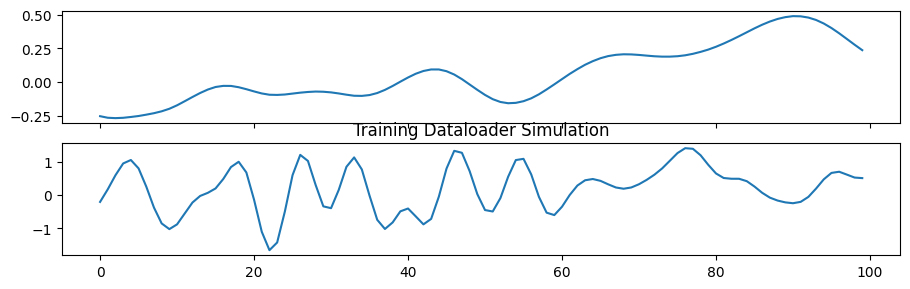

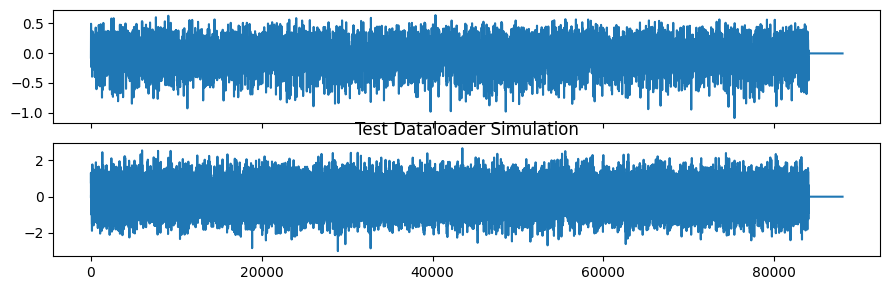

In [ ]:
dls = create_dls(u=['u'],y=['y'],dataset=f_path,dls_id='wh')
dls.show_batch(max_n=1)
plt.title('Training Dataloader Simulation')
dls[2].show_batch(max_n=1)
plt.title('Test Dataloader Simulation')

Text(0.5, 1.0, 'Test Dataloader Prediction')

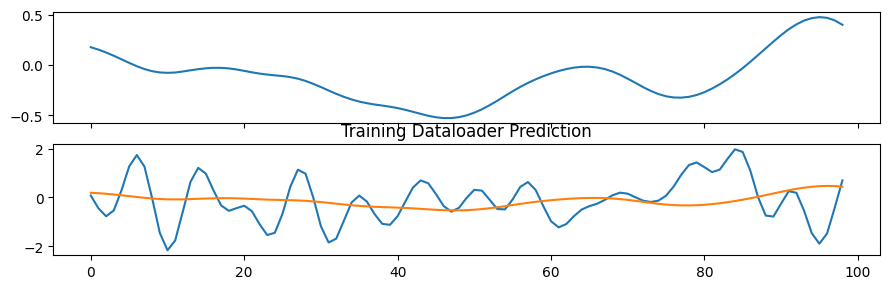

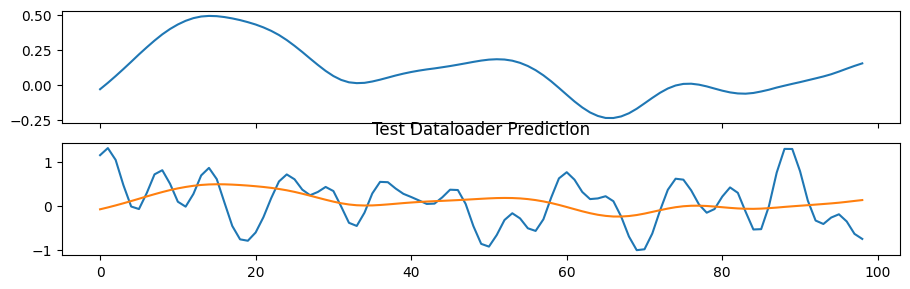

In [ ]:
dls = create_dls(u=['u'],y=['y'],dataset=f_path,dls_id='wh',prediction=True)
dls.show_batch(max_n=1)
plt.title('Training Dataloader Prediction')
dls[2].show_batch(max_n=1)
plt.title('Test Dataloader Prediction')

Text(0.5, 1.0, 'Test Dataloader Prediction')

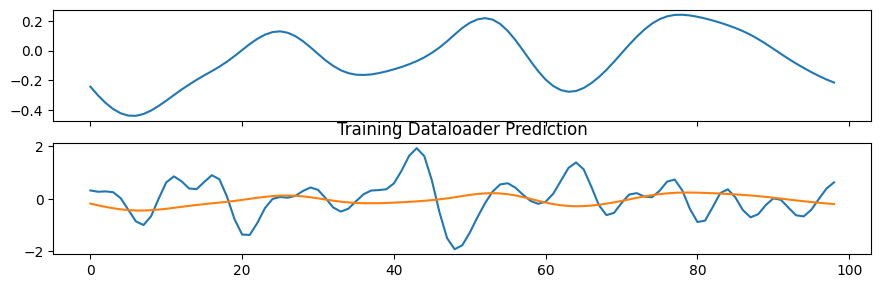

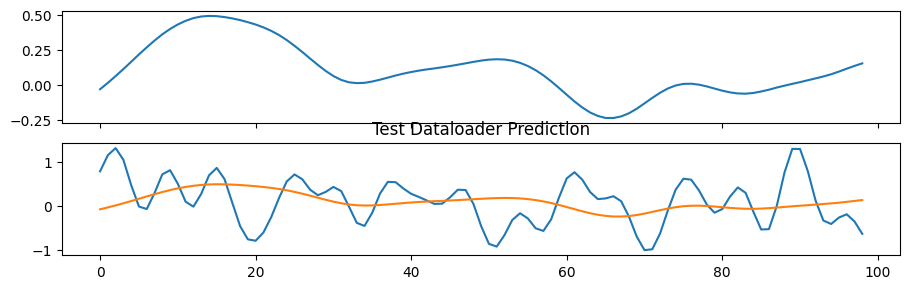

In [ ]:
dls = create_dls(u=['u'],y=['y'],dataset=f_path,dls_id='wh',prediction=True,input_delay=True)
dls.show_batch(max_n=1)
plt.title('Training Dataloader Prediction')
dls[2].show_batch(max_n=1)
plt.title('Test Dataloader Prediction')

In [ ]:
# def loader_factory(**defaults):
    
#     @delegates(create_dataloader)
#     def loader(**kwargs):
#         combined_args = {**defaults, **kwargs}
#         return create_dataloader(**combined_args)
    
#     return loader

# create_dls_test = loader_factory(
#         u=['u'],y=['y'],
#         dataset=f_path,
#         win_sz=100,
#         stp_sz=100
#     )

In [ ]:
#| export
create_dls_test = partial(
        create_dls, 
        u=['u'],y=['y'],
        dataset=get_config().config_file.parent / 'test_data/WienerHammerstein',
        win_sz=100,
        stp_sz=100
    )
create_dls_test.__doc__ = 'create a dataloader from a small dataset provided with tsfast'

In [ ]:
dls = create_dls_test()

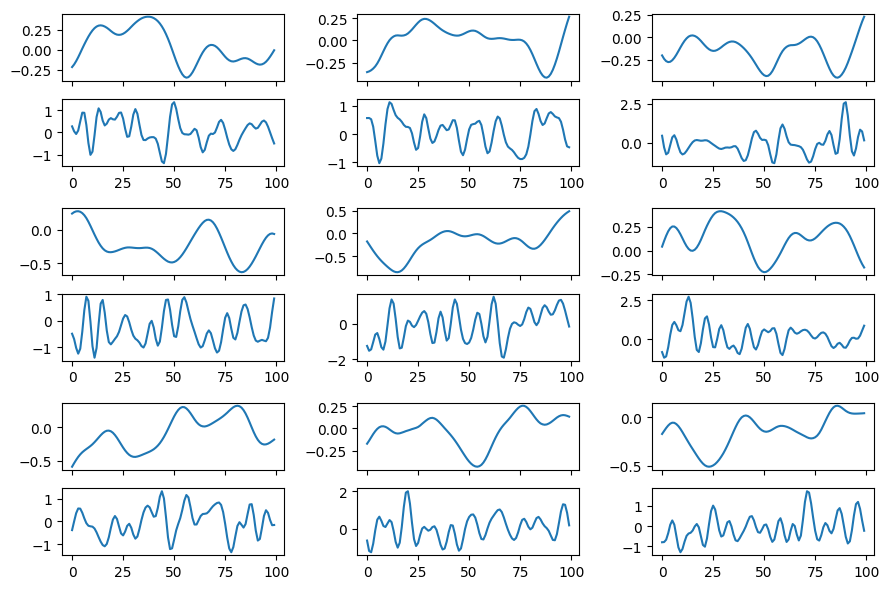

In [ ]:
dls.show_batch()

## External Data

In [ ]:
#| export
def get_default_dataset_path():
    "Create a directory in the user's home directory for storing datasets"
    data_dir = Path.home() / '.tsfast' / 'datasets'
    data_dir.mkdir(parents=True, exist_ok=True)
    return data_dir

In [ ]:
get_default_dataset_path()

Path('/Users/daniel/.tsfast/datasets')

In [ ]:
#| export
def get_dataset_path():
    "Retrieves the tsfast dataset directory. Tries to read the path in the environment variable 'TSFAST_PATH', returns the default otherwise."
    env_var_name = 'TSFAST_PATH'
    env_path = os.getenv(env_var_name)

    if env_path:
        return Path(env_path)
    else:
        return get_default_dataset_path()

In [ ]:
env_path = '/directory/.tsfast/'
os.environ['TSFAST_PATH'] = env_path
test_eq(get_dataset_path(),Path(env_path))
get_dataset_path()

Path('/directory/.tsfast')

In [ ]:
os.environ['TSFAST_PATH'] = ''
get_dataset_path()

Path('/Users/daniel/.tsfast/datasets')

In [ ]:
#| export
def clean_default_dataset_path():
    "Removes the default directory where the datasets are stored"
    rmtree(get_default_dataset_path())

In [ ]:
#| export
@delegates(create_dls, keep=True)
def create_dls_downl(
    dataset=None,#path to the dataset directory, if not provided uses default
    download_function=None,# function 
    **kwargs
):
    if dataset is None and download_function is not None:
        dataset = get_dataset_path() / download_function.__name__
    else:
        dataset = Path(dataset)

    if not is_dataset_directory(dataset):
        if download_function is not None:
            print(f'Dataset not found. Downloading it to "{dataset}"')
            download_function(dataset)
        else:
            raise ValueError(f'{dataset} does not contain a dataset. Check the path or activate the download flag.')

    return create_dls(dataset=dataset,**kwargs)

In [ ]:
#| hide
#os.remove('dls_normalize.p')

In [ ]:
#| include: false'
import nbdev; nbdev.nbdev_export()